In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import os

import numpy as np
import pandas as pd

import time 
import umap
import MulticoreTSNE

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import zipfile
import imageio
import os

import umap
import MulticoreTSNE

import sklearn.manifold
sns.set(context='poster', rc={'figure.figsize':(12, 10)})

### Pull the data from the internet and write it to a file

In [7]:
%%time
if not os.path.isfile('coil20.zip'):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip')
    with open("coil20.zip", "wb") as code:
        code.write(results.content)

CPU times: user 102 µs, sys: 45 µs, total: 147 µs
Wall time: 117 µs


### Read in from file and transform into a vector space

We add a filter to ensure that we only parse png files from our download zip.

In [9]:
import re
images_zip = zipfile.ZipFile('coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))

Next we pull the object id's from the file names using pandas

In [10]:
if not os.path.isfile('coil-20-proc/obj10__1.png'):
    !unzip coil20.zip

In [11]:
%%time
feature_vectors = []
for filename in filelist:
    im = imageio.imread(filename)
    feature_vectors.append(im.flatten())

CPU times: user 732 ms, sys: 247 ms, total: 979 ms
Wall time: 1.2 s


### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

We could leave this data in numpy arrays for improved efficiency but at data sizes this small the added functionality of pandas for potential exploration is appealing.

In [12]:
labels = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False)

In [13]:
data = np.array(pd.DataFrame(feature_vectors, index=labels))
data.shape

(1440, 16384)

### Now let's use UMAP to embed these points into a two dimensional space.

In [20]:
timings = []
dims = []
dimensions = [2,4,6,8]
for dim in dimensions:
    for rep in range(5):
        start = time.time()
        embedding = umap.UMAP(n_components=dim, n_neighbors=5, metric='euclidean').fit_transform(data)
        total_time = time.time()- start
        dims.append(dim)
        timings.append(total_time)
        print("dim: {} timing:{}".format(dim,total_time))

    

dim: 2 timing:2.496410846710205
dim: 2 timing:2.2667789459228516
dim: 2 timing:2.223145008087158
dim: 2 timing:2.220003843307495
dim: 2 timing:2.315018892288208
dim: 4 timing:2.361772060394287
dim: 4 timing:2.4360339641571045
dim: 4 timing:2.4476089477539062
dim: 4 timing:2.3542051315307617
dim: 4 timing:2.5121281147003174
dim: 6 timing:2.6396090984344482
dim: 6 timing:2.5394790172576904
dim: 6 timing:2.6010940074920654
dim: 6 timing:2.508117914199829
dim: 6 timing:2.940246105194092
dim: 8 timing:2.5919229984283447
dim: 8 timing:2.741640090942383
dim: 8 timing:2.6133170127868652
dim: 8 timing:2.668729066848755
dim: 8 timing:2.667729139328003


In [ ]:
d_umap = pd.DataFrame({'dimension':dims,'timing':timings})

### T-SNE

In [16]:
tsne_timings = []
tsne_dims = []
dimensions = [2,4,6,8]
for dim in dimensions:
    for rep in range(5):
        start = time.time()
        fit_tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=1, n_components=dim).fit_transform(data)
        #embedding = umap.UMAP(n_components=dim, n_neighbors=5, metric='euclidean').fit_transform(data)
        total_time = time.time()- start
        tsne_dims.append(dim)
        tsne_timings.append(total_time)
        print("dim: {} timing:{}".format(dim,total_time))

    

dim: 2 timing:18.347551107406616
dim: 2 timing:18.2344229221344
dim: 2 timing:18.215471982955933
dim: 2 timing:17.95185899734497
dim: 2 timing:18.15052604675293
dim: 4 timing:31.864727020263672
dim: 4 timing:31.418901920318604
dim: 4 timing:31.423667907714844
dim: 4 timing:31.262316942214966
dim: 4 timing:31.754092931747437
dim: 6 timing:98.60741114616394
dim: 6 timing:101.79274201393127
dim: 6 timing:96.73577880859375
dim: 6 timing:98.16109800338745
dim: 6 timing:98.64979386329651
dim: 8 timing:372.9771339893341
dim: 8 timing:380.99756503105164
dim: 8 timing:356.07248711586
dim: 8 timing:370.06342601776123
dim: 8 timing:400.7876648902893


In [25]:
#d.to_csv('timingScalingWithEmbeddingDimension_coil.csv')
d_tsne = pd.DataFrame({'dimension':tsne_dims, 'timing':tsne_timings})

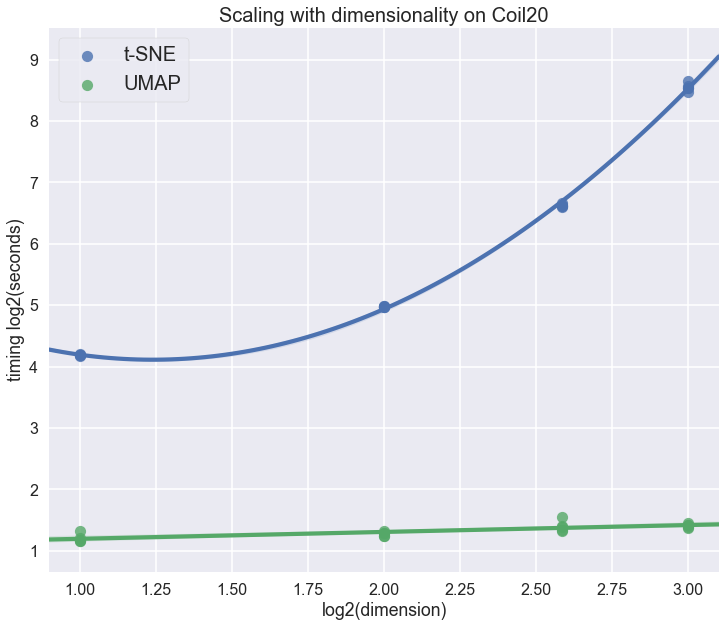

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)

#sns.regplot(x='dimension',y='timing',data=d_tsne,ax=ax, label='t-SNE', order=2)
#sns.regplot(x='dimension',y='timing',data=d_umap,ax=ax, label='UMAP')
sns.regplot(x='dimension',y='timing',data=np.log2(d_tsne),ax=ax, label='t-SNE', order=2)
sns.regplot(x='dimension',y='timing',data=np.log2(d_umap),ax=ax, label='UMAP')
plt.ylabel('timing log2(seconds)')
plt.xlabel('log2(dimension)')

plt.legend(loc='best', frameon=True, fancybox=True, fontsize=20)
plt.title('Scaling with dimensionality on Coil20', fontsize=20)
plt.savefig('scalingWithDimensionalityComparisonCoil20_log.png')

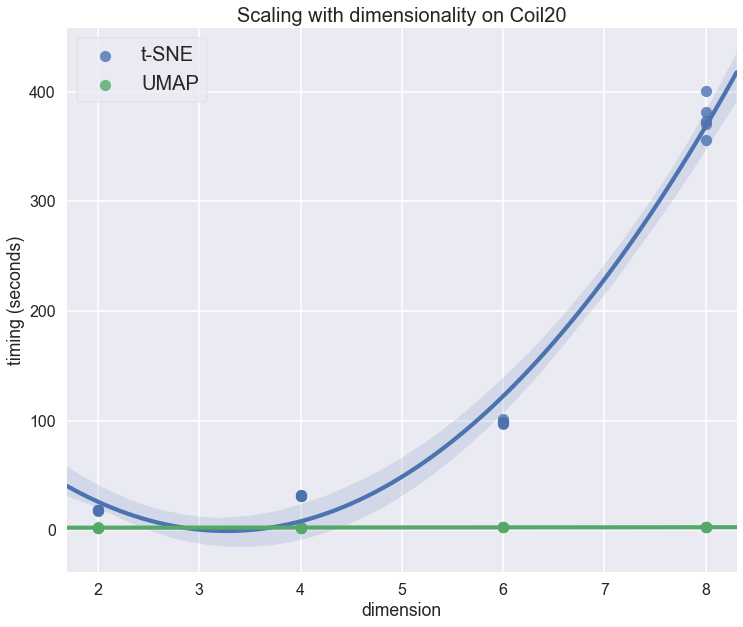

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.regplot(x='dimension',y='timing',data=d_tsne,ax=ax, label='t-SNE', order=2)
sns.regplot(x='dimension',y='timing',data=d_umap,ax=ax, label='UMAP')
plt.ylabel('timing (seconds)')

plt.legend(loc='best', frameon=True, fancybox=True, fontsize=20)
plt.title('Scaling with dimensionality on Coil20', fontsize=20)
plt.savefig('scalingWithDimensionalityComparisonCoil20.png')

## Test UMAP scaling to much higher dimensions.

In [41]:
large_timings = []
large_dims = []
dimensions = [2,4,8, 16, 32,64,128,256,512,1028]
for dim in dimensions:
    for rep in range(5):
        start = time.time()
        embedding = umap.UMAP(n_components=dim, n_neighbors=5, metric='euclidean').fit_transform(data)
        total_time = time.time()- start
        large_dims.append(dim)
        large_timings.append(total_time)
        print("dim: {} timing:{}".format(dim,total_time))

    

dim: 2 timing:2.3989179134368896
dim: 2 timing:2.2924771308898926
dim: 2 timing:2.245406150817871
dim: 2 timing:2.34148907661438
dim: 2 timing:2.3931970596313477
dim: 4 timing:2.4192869663238525
dim: 4 timing:2.438760995864868
dim: 4 timing:2.401902198791504
dim: 4 timing:2.390104055404663
dim: 4 timing:2.4117071628570557
dim: 8 timing:2.6936779022216797
dim: 8 timing:2.6808319091796875
dim: 8 timing:2.619980812072754
dim: 8 timing:2.6511361598968506
dim: 8 timing:2.7080209255218506
dim: 16 timing:2.757575035095215
dim: 16 timing:2.7809648513793945
dim: 16 timing:2.8393590450286865
dim: 16 timing:2.812641143798828
dim: 16 timing:2.797096014022827
dim: 32 timing:3.277150869369507
dim: 32 timing:3.4223761558532715
dim: 32 timing:3.2891428470611572
dim: 32 timing:3.267019033432007
dim: 32 timing:3.2928659915924072
dim: 64 timing:4.207239866256714
dim: 64 timing:4.272096872329712
dim: 64 timing:4.243464946746826
dim: 64 timing:4.213324069976807
dim: 64 timing:4.242082834243774
dim: 128 tim

ValueError: k must be between 1 and the order of the square input matrix.

In [47]:
d_large = pd.DataFrame({'dimension':large_dims, 'timing':large_timings})

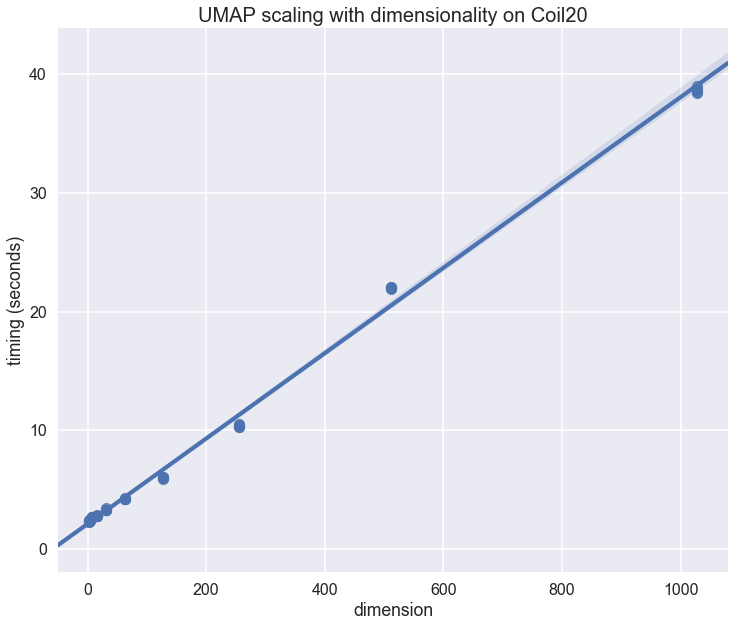

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.regplot(x='dimension',y='timing',data=d_large,ax=ax, label='UMAP')
plt.ylabel('timing (seconds)')
#plt.legend(loc='best', frameon=True, fancybox=True, fontsize=20)
plt.title('UMAP scaling with dimensionality on Coil20', fontsize=20)
plt.savefig('scalingWithDimensionalityUMAPCoil20.png')